# Statistical Analysis STAR-RIS Assisted CoMP-NOMA

In [1]:
import numpy as np
import scipy as sp
from scipy.special import gamma
import matplotlib.pyplot as plt
import simcomm.core.propagation as prop
from simcomm.core import Nakagami, get_rvs
from simcomm.utils import dbm2pow, db2pow
from simcomm.core.propagation import get_noise_power, get_pathloss

In [2]:
environment = {
    "positions": {
        "BS1": [-50, 0, 25],  # BS1 position
        "BS2": [50, 0, 25],  # BS2 position
        "RIS": [0, 25, 5],  # RIS position
        "Uf": [0, 35, 1],  # Uf position
        "U1c": [-40, 18, 1],  # U1c position
        "U2c": [30, 22, 1],  # U2c position
    },
    "fading": {
        "rayleigh": {"type": "rayleigh", "sigma": 1},  # Rayleigh fading
        "ricianE": {
            "type": "rician",
            "K": 5,
            "sigma": 1,
        },  # Rician fading for edge users
        "ricianC": {
            "type": "rician",
            "K": 3,
            "sigma": 1,
        },  # Rician fading for center users
        "nakagami-1": {"type": "nakagami", "m": 1, "omega": 1},  # Nakagami-m fading
        "nakagami-2": {"type": "nakagami", "m": 2, "omega": 1},  # Nakagami-m fading
    },
    "pathloss": {
        "center": {"type": "free-space", "alpha": 3, "p0": 30},  # Center users
        "ris": {"type": "free-space", "alpha": 3, "p0": 30},  # BS to RIS
        "risC": {"type": "free-space", "alpha": 2.7, "p0": 30},  # RIS to center users
        "risE": {"type": "free-space", "alpha": 2.3, "p0": 30},  # RIS to Fedge user
        "edge": {"type": "free-space", "alpha": 3.5, "p0": 30},  # Edge users
        "inter": {"type": "free-space", "alpha": 4, "p0": 30},  # Interference links
    },
}

setting = {
    "ris32": {
        "ris_enhanced": True,  # RIS with 32 elements
        "ris_elements": 32,
        "comp_enabled": True,  # CoMP enabled
    },
    "no_ris": {
        "ris_enhanced": False,  # No RIS
        "comp_enabled": True,  # CoMP enabled"
    },
    "ris70": {
        "ris_enhanced": True,  # RIS with 70 elements
        "ris_elements": 70,
        "comp_enabled": True,  # CoMP enabled
    },
    "no_ris_non_comp": {
        "ris_enhanced": False,  # No RIS
        "comp_enabled": False,  # CoMP disabled
    },
}

constants = {
    "BANDWIDTH": 1e6,  # Bandwidth in Hz
    "TEMP": 300,  # Temperature in Kelvin
    "FREQ": 2.4e9,  # Frequency of carrier signal in Hz
    "SIGMA": 6.32,  # Shadowing standard deviation in dB
}

# Load the environment
pathloss_cfg = environment["pathloss"]
fading_cfg = environment["fading"]
positions = environment["positions"]

# Additional parameters
BANDWIDTH = constants["BANDWIDTH"]  # Bandwidth in Hz
TEMP = constants["TEMP"]  # Temperature in Kelvin
FREQ = constants["FREQ"]  # Frequency of carrier signal in Hz
SIGMA = constants["SIGMA"]  # Shadowing standard deviation in dB

## Simulation

In [3]:
distance_iR = 50
distance_Rc = 20
distance_ic = 65
K = 20
N = 10000

frequency = 2.4e9
shape = (N, 1)
shape_ris = (K, N, 1)

pathloss_iR = get_pathloss(
    **pathloss_cfg["ris"], distance=distance_iR, frequency=frequency
)
pathloss_Rc = get_pathloss(
    **pathloss_cfg["risC"], distance=distance_Rc, frequency=frequency
)
pathloss_ic = get_pathloss(
    **pathloss_cfg["center"], distance=distance_ic, frequency=frequency
)
# np.sqrt(db2pow(-1 * self.pathloss))

samples_iR = get_rvs(**{"type": "nakagami", "m": 2, "omega": 1}, shape=shape_ris)
samples_Rc = get_rvs(**{"type": "nakagami", "m": 2, "omega": 1}, shape=shape_ris)
samples_ic = get_rvs(**{"type": "nakagami", "m": 1, "omega": 1}, shape=shape)

In [4]:
h_iR = np.abs(np.sqrt(db2pow(-1 * pathloss_iR)) * samples_iR)
h_Rc = np.abs(np.sqrt(db2pow(-1 * pathloss_Rc)) * samples_Rc)
h_ic = np.abs(np.sqrt(db2pow(-1 * pathloss_ic)) * samples_ic)

cascaded = np.sum(h_iR * h_Rc, axis=0)
effective = cascaded + h_ic

### Statistics

### Effective Channel Gain Derivation

Effective Channel $\textbf{H}_{i, c}=\textbf{h}_{i, c}+\textbf{h}_{R, c}^H \mathbf{\Theta_r}\textbf{h}_{i, R}$

Channel Gain $Z_{i,c} = |H_{i,c}|^2 = (h_{i,c} + G_{i,R,c})^2$

Direct Channel $h_{i,c}$

In [5]:
m_ic = 1
omega_ic = 1 * db2pow(-1 * pathloss_ic)

In [6]:
def fun_mu_h_ic(p, m_ic, omega_ic):
    return (gamma(m_ic + p / 2) / gamma(m_ic)) * (m_ic / omega_ic) ** (-p / 2)

In [7]:
mu_h_ic = fun_mu_h_ic(1, m_ic, omega_ic)  # 1st moment of h_ic
mu_h_ic_2 = fun_mu_h_ic(2, m_ic, omega_ic)  # 2nd moment of h_ic

k_h_ic = (mu_h_ic**2) / (mu_h_ic_2 - mu_h_ic**2)  # Shape parameter of h_ic
theta_h_ic = (mu_h_ic_2 - mu_h_ic**2) / mu_h_ic  # Scale parameter of h_ic

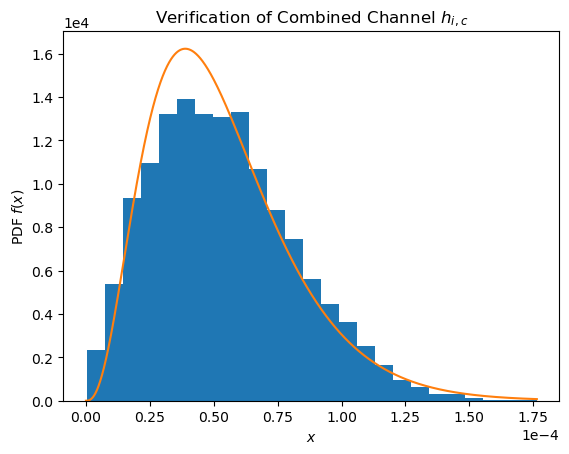

In [8]:
x = np.linspace(0, np.max(h_ic), N)
plt.hist(h_ic, bins=25, density=True)
plt.plot(
    x,
    sp.stats.gamma.pdf(x, k_h_ic, scale=theta_h_ic),
)
plt.title(r"Verification of Combined Channel $h_{i,c}$")
plt.xlabel(r"$x$")
plt.ylabel(r"PDF $f(x)$")
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.show()

Cascaded Channel $G_{i,R,c} = \sum_{k=1}^{K} |{h_{R,f}}||{h_{i,R}}|$

In [9]:
m_iR = 2
m_Rc = 2
omega_iR = 1 * db2pow(-1 * pathloss_iR)
omega_Rc = 1 * db2pow(-1 * pathloss_Rc)

In [10]:
def fun_mu_h_iR(p, m_iR, omega_iR):
    return gamma(m_iR + p / 2) / gamma(m_iR) * (m_iR / omega_iR) ** (-p / 2)

def fun_mu_h_Rc(p, m_Rc, omega_Rc):
    return gamma(m_Rc + p / 2) / gamma(m_Rc) * (m_Rc / omega_Rc) ** (-p / 2)

In [11]:
mu_G_iRc = (
    K * fun_mu_h_iR(1, m_iR, omega_iR) * fun_mu_h_Rc(1, m_Rc, omega_Rc)
)  # 1st moment of G_iRc
sigma2_G_iRc = K * (
    omega_iR * omega_Rc
    - (fun_mu_h_iR(1, m_iR, omega_iR) ** 2 * fun_mu_h_Rc(1, m_Rc, omega_Rc) ** 2)
)  # Variance of G_iRc (2nd moment - 1st moment squared)
mu_G_iRc_2 = sigma2_G_iRc + mu_G_iRc**2  # 2nd moment of G_iRc

k_G_iRc = mu_G_iRc**2 / (mu_G_iRc_2 - mu_G_iRc**2)  # Shape parameter of G_iRc
theta_G_iRc = (mu_G_iRc_2 - mu_G_iRc**2) / mu_G_iRc  # Scale parameter of G_iRc

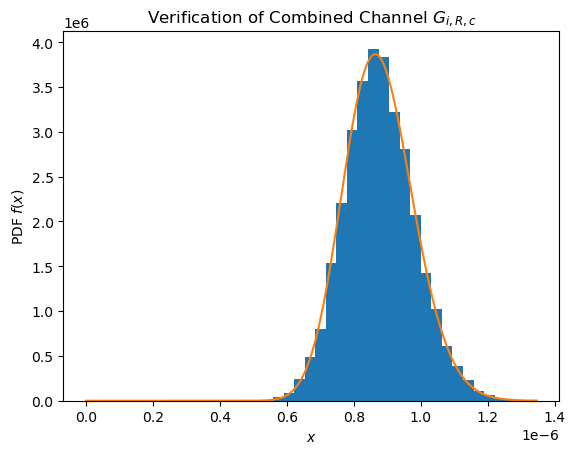

In [12]:
x = np.linspace(0, np.max(cascaded), N)
plt.hist(cascaded, bins=25, density=True)
plt.plot(
    x,
    sp.stats.gamma.pdf(x, k_G_iRc, scale=theta_G_iRc),
)
plt.title(r"Verification of Combined Channel $G_{i,R,c}$")
plt.xlabel(r"$x$")
plt.ylabel(r"PDF $f(x)$")
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.show()

Effective Channel Gain $Z_{i,c} = |H_{i,c}|^2 = (h_{i,c} + G_{i,R,c})^2$

In [13]:
def fun_mu_G_iRc(p, m_iR, omega_iR, m_Rc, omega_Rc, K):
    mu = (gamma(m_iR + (1 / 2)) * gamma(m_Rc + (1 / 2))) / (
        gamma(m_iR) * gamma(m_Rc) * (m_iR * m_Rc) ** (1 / 2)
    )
    k = mu**2 / (1 - mu**2)
    theta = (1 - mu**2) / mu

    return (gamma((K * k) + p) * (np.sqrt(omega_iR * omega_Rc) * theta) ** p) / gamma(
        K * k
    )

In [14]:
mu_Z_ic = (
    fun_mu_G_iRc(2, m_iR, omega_iR, m_Rc, omega_Rc, K)
    + fun_mu_h_ic(2, m_ic, omega_ic)
    + (
        2
        * fun_mu_G_iRc(1, m_iR, omega_iR, m_Rc, omega_Rc, K)
        * fun_mu_h_ic(1, m_ic, omega_ic)
    )
)

mu_Z_ic_2 = (
    fun_mu_G_iRc(4, m_iR, omega_iR, m_Rc, omega_Rc, K)
    + fun_mu_h_ic(4, m_ic, omega_ic)
    + (
        6
        * fun_mu_G_iRc(2, m_iR, omega_iR, m_Rc, omega_Rc, K)
        * fun_mu_h_ic(2, m_ic, omega_ic)
    )
    + (
        4
        * fun_mu_h_ic(3, m_ic, omega_ic)
        * fun_mu_G_iRc(1, m_iR, omega_iR, m_Rc, omega_Rc, K)
    )
    + (
        4
        * fun_mu_h_ic(1, m_ic, omega_ic)
        * fun_mu_G_iRc(3, m_iR, omega_iR, m_Rc, omega_Rc, K)
    )
)

k_Z_ic = mu_Z_ic**2 / (mu_Z_ic_2 - mu_Z_ic**2)  # Shape parameter of Z_ic
theta_Z_ic = (mu_Z_ic_2 - mu_Z_ic**2) / mu_Z_ic  # Scale parameter of Z_ic

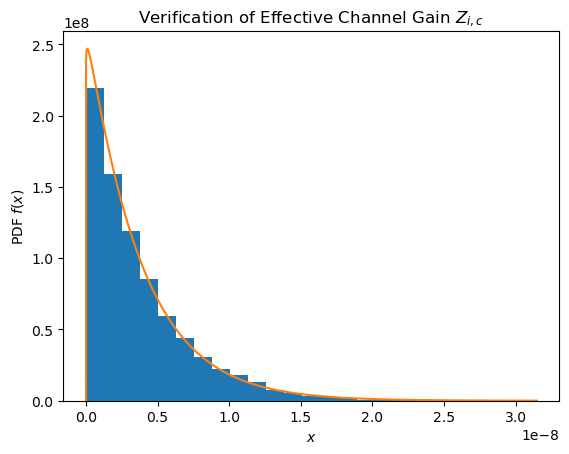

In [15]:
x = np.linspace(0, np.max(effective)**2, N)
plt.hist(effective**2, bins=25, density=True)
plt.plot(
    x,
    sp.stats.gamma.pdf(x, k_Z_ic, scale=theta_Z_ic),
)
plt.title(r"Verification of Effective Channel Gain $Z_{i,c}$")
plt.xlabel(r"$x$")
plt.ylabel(r"PDF $f(x)$")
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.show()